In [1]:
# 1. IMPORTAR BIBLIOTECAS E MONTAR O GOOGLE DRIVE
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from google.colab import drive
import os
import matplotlib.pyplot as plt

In [2]:
# Monta o Google Drive para que o Colab possa acessar os arquivos
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 2. DESCOMPACTAR O DATASET
# Altere o caminho abaixo se salvou o ZIP em outra pasta no Drive!
zip_path = '/content/drive/MyDrive/raw_dataset.zip'
extract_path = '/content/dataset'

# Usamos o comando "unzip" do sistema para descompactar os dados
!unzip -q {zip_path} -d {extract_path}

# O dataset que você escolheu pode ter uma pasta aninhada, vamos apontar para o diretório certo
# Verifique o nome da pasta após descompactar. Geralmente é a pasta 'raw'.
data_dir = os.path.join(extract_path, 'raw')
print("Conteúdo da pasta do dataset:", os.listdir(data_dir))

Conteúdo da pasta do dataset: ['direita', 'parar', 'esquerda', 'frente']


In [4]:
# 3. DEFINIR PARÂMETROS E CARREGAR OS DADOS
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 32 # Quantas imagens processar por vez

# Carregar o dataset de treinamento (80% dos dados)
# O Keras infere as classes (left, right, etc.) a partir dos nomes das pastas!
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2, # Vamos separar 20% para validação
    subset="training",
    seed=123, # Semente para garantir que a divisão seja sempre a mesma
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

# Carregar o dataset de validação (os 20% restantes)
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

# Imprimir os nomes das classes que o Keras encontrou
class_names = train_dataset.class_names
print("Classes encontradas:", class_names)
num_classes = len(class_names)


Found 3684 files belonging to 4 classes.
Using 2948 files for training.
Found 3684 files belonging to 4 classes.
Using 736 files for validation.
Classes encontradas: ['direita', 'esquerda', 'frente', 'parar']


In [5]:
# Célula 4 (ou onde estiver a augmentation) ATUALIZADA

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),  # Aumentamos um pouco a rotação
    layers.RandomZoom(0.2),      # Aumentamos um pouco o zoom
    layers.RandomContrast(0.2),  # NOVO: Varia o contraste
    layers.RandomBrightness(0.2) # NOVO: Varia o brilho
])

In [6]:
# 5. CONSTRUIR O MODELO DA REDE NEURAL CONVOLUCIONAL (CNN)
model = keras.Sequential([
    keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    # Camada de Augmentation para "enriquecer" os dados de treino
    data_augmentation,
    # Normaliza os valores dos pixels de [0, 255] para [0, 1]
    layers.Rescaling(1./255),

    # Bloco Convolucional 1
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Bloco Convolucional 2
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Bloco Convolucional 3
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Remove neurônios aleatoriamente para evitar overfitting
    layers.Dropout(0.4),

    # Achata os dados para entrar na rede densa
    layers.Flatten(),

    # Camada densa com 128 neurônios
    layers.Dense(128, activation='relu'),

    # Camada de saída - o número de neurônios deve ser igual ao número de classes
    layers.Dense(num_classes, activation='softmax')
])

In [7]:
# 6. COMPILAR O MODELO
# Define o otimizador, a função de perda e a métrica de avaliação
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Mostra um resumo da arquitetura do modelo
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 548,516 (2.09 MB)

 Trainable params: 548,516 (2.09 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# 7. TREINAR O MODELO
epochs = 25 # Quantas vezes o modelo verá todo o dataset
history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)

Epoch 1/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.4102 - loss: 1.2217 - val_accuracy: 0.6250 - val_loss: 0.7398
Epoch 2/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.5860 - loss: 0.8692 - val_accuracy: 0.8315 - val_loss: 0.5375
Epoch 3/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.6850 - loss: 0.7312 - val_accuracy: 0.8859 - val_loss: 0.3596
Epoch 4/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.7334 - loss: 0.6386 - val_accuracy: 0.8832 - val_loss: 0.3449
Epoch 5/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.7548 - loss: 0.5781 - val_accuracy: 0.9062 - val_loss: 0.2583
Epoch 6/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.7853 - loss: 0.5081 - val_accuracy: 0.9389 - val_loss: 0.2194
Epoch 7/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8051 - loss: 0.4898 - val_accuracy: 0.9035 - val_loss: 0.2662
Epoch 8/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.8168 - loss: 0.4531 - val_accuracy: 0.9443 - 

Gerando previsões para o conjunto de validação...


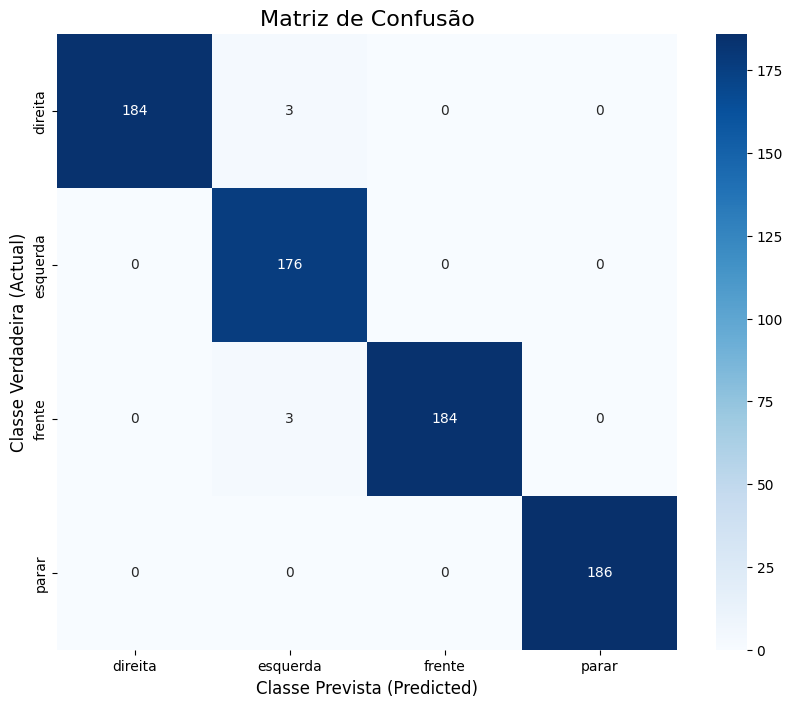


Relatório de Classificação Detalhado:

              precision    recall  f1-score   support

     direita       1.00      0.98      0.99       187
    esquerda       0.97      1.00      0.98       176
      frente       1.00      0.98      0.99       187
       parar       1.00      1.00      1.00       186

    accuracy                           0.99       736
   macro avg       0.99      0.99      0.99       736
weighted avg       0.99      0.99      0.99       736



In [9]:
# ANÁLISE DE PERFORMANCE COM MATRIZ DE CONFUSÃO
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

print("Gerando previsões para o conjunto de validação...")

# Pega todos os rótulos verdadeiros e as previsões do modelo
# para o conjunto de dados de validação.
all_true_labels = []
all_predictions = []

for images, labels in validation_dataset:
  # Faz a previsão para um lote de imagens
  predictions_batch = model.predict(images, verbose=0)
  # A predição é um array de probabilidades, pegamos o índice da maior probabilidade
  predictions_indices = np.argmax(predictions_batch, axis=1)

  # Adiciona os rótulos e as previsões do lote às listas gerais
  all_predictions.extend(predictions_indices)
  all_true_labels.extend(labels.numpy())

# Cria a matriz de confusão
cm = confusion_matrix(all_true_labels, all_predictions)

# Plota a matriz de confusão de forma visual
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.title('Matriz de Confusão', fontsize=16)
plt.ylabel('Classe Verdadeira (Actual)', fontsize=12)
plt.xlabel('Classe Prevista (Predicted)', fontsize=12)
plt.show()

# Opcional: Imprime um relatório de classificação com mais métricas (precisão, recall, f1-score)
print("\nRelatório de Classificação Detalhado:\n")
print(classification_report(all_true_labels, all_predictions, target_names=class_names))

In [10]:
# 8. CONVERTER E SALVAR O MODELO PARA TENSORFLOW LITE (.tflite)
print("\nIniciando conversão para TensorFlow Lite...")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Salvar o modelo .tflite
with open('sign_classifier.tflite', 'wb') as f:
  f.write(tflite_model)

print("Modelo 'sign_classifier.tflite' salvo com sucesso!")


Iniciando conversão para TensorFlow Lite...
Saved artifact at '/tmp/tmpw6nf2mco'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  138690715236496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138690715237264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138690675737232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138690675739344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138690675738768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138690675740112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138690675739536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138690675740880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138690675740304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138690675741648: TensorSpec(shape=(), dty

In [11]:
# 9. FAZER O DOWNLOAD DO MODELO TREINADO
from google.colab import files
files.download('sign_classifier.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>